# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Pandas used to import dataset, additional libraries are added for use later in code.

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1
5,phon_R01_S01_6,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,...,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,1
6,phon_R01_S02_1,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,...,0.02337,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1
7,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755,1
8,phon_R01_S02_3,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,...,0.03218,0.01070,21.812,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571,1
9,phon_R01_S02_4,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,...,0.04324,0.01022,21.862,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362,1


Display data table

# Split Dataset

In [4]:
x = df.loc[:,'MDVP:Fo(Hz)':'PPE'].values
y = df.loc[:,'status'].values

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x,y,
                        test_size = 0.2,
                        stratify = y,
                        random_state = 6000)

Splitting the data for training a knn classifier in a holdout + cross-validation fashion. Split data is used to establish graphs plotted later in code.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [7]:
pipe_K = make_pipeline(StandardScaler(),PCA(n_components=2),KNeighborsClassifier())

In [8]:
pipe_K.fit(x_train, y_train)
y_predict = pipe_K.predict(x_test)
print('TEST ACCURACY: %.3f'% pipe_K.score(x_test,y_test))

TEST ACCURACY: 0.872


Find the test accuracy using the "make_pipeline" function to establish pipe_K.

In [9]:
from sklearn.grid_search import GridSearchCV

k = [4,5,6,7,8,9,10]
param_grid = [{'kneighborsclassifier__n_neighbors': k}]

grids = GridSearchCV(estimator=pipe_K, param_grid=param_grid, scoring='accuracy', cv = 5)

grids = grids.fit(x_train, y_train)
print(grids.best_score_)
print(grids.best_params_)

0.8717948717948718
{'kneighborsclassifier__n_neighbors': 9}


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Imput k values into the k-nearest neighbors classifier. Then, using Grid Search, identify the optimal k.

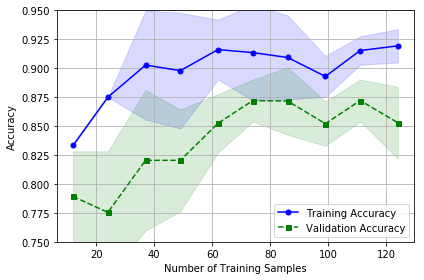

In [10]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
                learning_curve(estimator = pipe_K,
                              X = x_train,
                              y = y_train,
                              train_sizes=np.linspace(0.1, 1.0, 10),
                              cv = 5, n_jobs=1)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, label = 'Training Accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Validation Accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.75, .95])
plt.tight_layout()
plt.show()

The code above is the graph setup for the learning curve using matplotlib. Train data and test data are separated into 2 separate colors and marker types. Then, the "fill-between" function is used to connect data points, with a dotted connector for the validation accuracy. I limited the y scale in order to show all data points without including extra space.

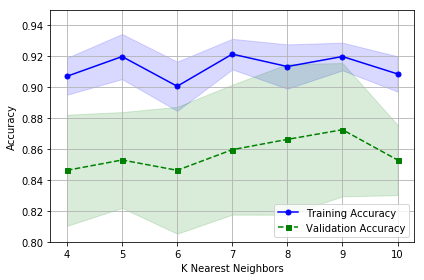

In [11]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
                estimator = pipe_K,
                X = x_train,
                y = y_train,
                param_name = 'kneighborsclassifier__n_neighbors',
                param_range = k,
                cv = 5)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(k, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, label = 'Training Accuracy')

plt.fill_between(k,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(k, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Validation Accuracy')

plt.fill_between(k,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.legend(loc = 'lower right')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')
plt.ylim([0.8, .95])
plt.tight_layout()
plt.show()

The code above is the graph setup for the validation curve using matplotlib. Train data and test data are separated into 2 separate colors and marker types. Then, the "fill-between" function is used to connect data points, with a dotted connector for the validation accuracy. I limited the y scale in order to show all data points without including extra space.